# Model Comparison: Baseline vs Improvement Attempts

This notebook runs all models and provides comparison of:

**Imbalance Handling Alternatives:**
- **SMOTENC**
- **Class Weights**

**Model Types:**

*Baseline:*
1. **Logistic Regression**
2. **Random Forest**

*Improvement Attempts:*

3. **XGBoost**: Gradient boosted trees
4. **FFNN**: Feed-forward neural network with dense layers
5. **Embeddings**: Neural network with learned embeddings for categorical features

**Evaluation Metrics:**
- Overall Accuracy
- Macro F1-Score (more appropriate for imbalanced classes)
- Precision, Recall, F1-Score

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

from src.preprocessing_pipeline import build_preprocessed_data

# Configuration
RANDOM_STATE = 207
np.random.seed(RANDOM_STATE)
plt.style.use('dark_background')

# Class labels for disp
CLASS_NAMES = ['small', 'medium', 'large', 'very large']

2025-12-13 08:31:51.980486: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-13 08:31:52.210288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-13 08:31:52.210465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-13 08:31:52.247677: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-13 08:31:52.320482: I tensorflow/core/platform/cpu_feature_guar

## Results Storage

In [2]:
# Dictionary for res storage
results = {
    'model': [],
    'imbalance_strategy': [],
    'model_type': [],  # 'baseline' or 'improvement'
    'val_accuracy': [],
    'val_macro_f1': [],
    'val_weighted_f1': [],
    'test_accuracy': [],
    'test_macro_f1': [],
    'test_weighted_f1': [],
    # Per-class F1 on val data
    'val_f1_small': [],
    'val_f1_medium': [],
    'val_f1_large': [],
    'val_f1_very_large': [],
    # Per-class recall on val data (important for minority classes)
    'val_recall_large': [],
    'val_recall_very_large': [],
}

def store_results(model_name, strategy, model_type, y_val, y_pred_val, y_test, y_pred_test):
    """Store evaluation metrics"""
    results['model'].append(model_name)
    results['imbalance_strategy'].append(strategy)
    results['model_type'].append(model_type)
    
    # Validation metrics
    results['val_accuracy'].append(accuracy_score(y_val, y_pred_val))
    results['val_macro_f1'].append(f1_score(y_val, y_pred_val, average='macro'))
    results['val_weighted_f1'].append(f1_score(y_val, y_pred_val, average='weighted'))
    
    # Test metrics
    results['test_accuracy'].append(accuracy_score(y_test, y_pred_test))
    results['test_macro_f1'].append(f1_score(y_test, y_pred_test, average='macro'))
    results['test_weighted_f1'].append(f1_score(y_test, y_pred_test, average='weighted'))
    
    # Per-class F1 on validation
    per_class_f1 = f1_score(y_val, y_pred_val, average=None)
    results['val_f1_small'].append(per_class_f1[0])
    results['val_f1_medium'].append(per_class_f1[1])
    results['val_f1_large'].append(per_class_f1[2])
    results['val_f1_very_large'].append(per_class_f1[3])
    
    # Per-class recall (important for minority classes)
    per_class_recall = recall_score(y_val, y_pred_val, average=None)
    results['val_recall_large'].append(per_class_recall[2])
    results['val_recall_very_large'].append(per_class_recall[3])

def print_evaluation(model_name, y_val, y_pred_val, y_test=None, y_pred_test=None):
    """Print detailed evaluation metrics."""
    print(f"{model_name}")
    
    print(f"\nValidation Accuracy: {accuracy_score(y_val, y_pred_val):.4f}")
    print(f"Validation Macro F1: {f1_score(y_val, y_pred_val, average='macro'):.4f}")
    print(f"\nClassification Report (Validation):")
    print(classification_report(y_val, y_pred_val, target_names=CLASS_NAMES))
    
    if y_test is not None and y_pred_test is not None:
        print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
        print(f"Test Macro F1: {f1_score(y_test, y_pred_test, average='macro'):.4f}")

# SMOTENC Models

In [3]:
print("Loading data with SMOTENC...")

data_smotenc = build_preprocessed_data(
    use_smote=True,
    smote_strategy='smotenc',
    impute_strategy='subgroup_mean',
    smote_minority_n=50_000,
    smote_majority_cap=100_000,
    output_format='standard'
)

X_train_smote = data_smotenc["X_train_std"]
y_train_smote = data_smotenc["Y_train"]
X_val_smote = data_smotenc["X_val_std"]
y_val_smote = data_smotenc["Y_val"]
X_test_smote = data_smotenc["X_test_std"]
y_test_smote = data_smotenc["Y_test"]

print(f"\nTraining shape: {X_train_smote.shape}")
print(f"Validation shape: {X_val_smote.shape}")
print(f"Test shape: {X_test_smote.shape}")
print(f"\nClass distribution in training (after SMOTE):")
unique, counts = np.unique(y_train_smote, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Class {cls} ({CLASS_NAMES[cls]}): {cnt}")

Loading data with SMOTENC...
[Memory] Pipeline start: 0.67 GB
Loading the file using Polars...
File loaded successfully with Polars. Shape: (2302521, 308)
Converted the Polars DataFrame to Pandas.
[Memory] After data load: 28.49 GB
Loaded 2302521 rows

Pre-sampling for SMOTE (minority_n=50000, majority_cap=100000)...
Original class distribution:
FIRE_SIZE_LABEL
small         2241807
medium          55930
large            3682
very large       1102
Name: count, dtype: int64
  small: sampled 100000 from 2241807
  medium: sampled 50000 from 55930
  large: sampled 3682 from 3682
  very large: sampled 1102 from 1102
Total sampled: 154784 rows
[Memory] After sampling: 23.52 GB
Imputing with subgroup mean (GACC_PL)...

Applying SMOTENC on pre-sampled data...
[Memory] Before SMOTENC: 21.07 GB
SMOTENC input shape: (92870, 45)
Class distribution before SMOTE:
FIRE_SIZE_LABEL
0    59995
1    29993
2     2219
3      663
Name: count, dtype: int64
[Memory] Before fit_resample: 21.07 GB
[Memory] Afte

## Baseline Models (SMOTENC)

### Logistic Regression

In [4]:
print("Training Logistic Regression (SMOTENC)...")

logreg_smote = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    n_jobs=-1
)
logreg_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_val_logreg_smote = logreg_smote.predict(X_val_smote)
y_pred_test_logreg_smote = logreg_smote.predict(X_test_smote)

# Store and print results
store_results('Logistic Regression', 'SMOTENC', 'baseline',
              y_val_smote, y_pred_val_logreg_smote,
              y_test_smote, y_pred_test_logreg_smote)

print_evaluation('Logistic Regression (Baseline) + SMOTENC',
                 y_val_smote, y_pred_val_logreg_smote,
                 y_test_smote, y_pred_test_logreg_smote)

Training Logistic Regression (SMOTENC)...
Logistic Regression (Baseline) + SMOTENC

Validation Accuracy: 0.5583
Validation Macro F1: 0.3283

Classification Report (Validation):
              precision    recall  f1-score   support

       small       0.78      0.67      0.72     20004
      medium       0.44      0.35      0.39     10004
       large       0.06      0.29      0.10       729
  very large       0.05      0.59      0.10       220

    accuracy                           0.56     30957
   macro avg       0.33      0.48      0.33     30957
weighted avg       0.65      0.56      0.60     30957


Test Accuracy: 0.5567
Test Macro F1: 0.3289


### Random Forest

In [5]:
print("Training Random Forest (SMOTENC)...")

rf_smote = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_val_rf_smote = rf_smote.predict(X_val_smote)
y_pred_test_rf_smote = rf_smote.predict(X_test_smote)

# Store and print results
store_results('Random Forest', 'SMOTENC', 'baseline',
              y_val_smote, y_pred_val_rf_smote,
              y_test_smote, y_pred_test_rf_smote)

print_evaluation('Random Forest (Baseline) + SMOTENC',
                 y_val_smote, y_pred_val_rf_smote,
                 y_test_smote, y_pred_test_rf_smote)

Training Random Forest (SMOTENC)...
Random Forest (Baseline) + SMOTENC

Validation Accuracy: 0.7232
Validation Macro F1: 0.4436

Classification Report (Validation):
              precision    recall  f1-score   support

       small       0.83      0.80      0.82     20004
      medium       0.60      0.61      0.61     10004
       large       0.15      0.24      0.18       729
  very large       0.16      0.18      0.17       220

    accuracy                           0.72     30957
   macro avg       0.44      0.46      0.44     30957
weighted avg       0.73      0.72      0.73     30957


Test Accuracy: 0.7224
Test Macro F1: 0.4370


## Improvement Attempts (SMOTENC)

### XGBoost

In [6]:
print("Training XGBoost (SMOTENC)...")

xgb_smote = XGBClassifier(
    n_jobs=-1,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_val_xgb_smote = xgb_smote.predict(X_val_smote)
y_pred_test_xgb_smote = xgb_smote.predict(X_test_smote)

# Store and print results
store_results('XGBoost', 'SMOTENC', 'improvement',
              y_val_smote, y_pred_val_xgb_smote,
              y_test_smote, y_pred_test_xgb_smote)

print_evaluation('XGBoost (Improvement) + SMOTENC',
                 y_val_smote, y_pred_val_xgb_smote,
                 y_test_smote, y_pred_test_xgb_smote)

Training XGBoost (SMOTENC)...
XGBoost (Improvement) + SMOTENC

Validation Accuracy: 0.7247
Validation Macro F1: 0.4371

Classification Report (Validation):
              precision    recall  f1-score   support

       small       0.82      0.82      0.82     20004
      medium       0.62      0.58      0.60     10004
       large       0.13      0.18      0.15       729
  very large       0.13      0.29      0.18       220

    accuracy                           0.72     30957
   macro avg       0.42      0.47      0.44     30957
weighted avg       0.73      0.72      0.73     30957


Test Accuracy: 0.7267
Test Macro F1: 0.4332


### Feed-Forward Neural Network (FFNN)

In [7]:
print("Training Feed-Forward Neural Network (SMOTENC)...")

def build_ffnn(input_dim, num_classes):
    """Build a simple FFNN model."""
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Prepare data
X_train_f32 = X_train_smote.astype('float32')
X_val_f32 = X_val_smote.astype('float32')
X_test_f32 = X_test_smote.astype('float32')
y_train_i32 = y_train_smote.astype('int32')

num_classes = len(np.unique(y_train_smote))
ffnn_smote = build_ffnn(X_train_f32.shape[1], num_classes)

# Training
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_ffnn_smote = ffnn_smote.fit(
    X_train_f32, y_train_i32,
    epochs=50,
    batch_size=256,
    validation_data=(X_val_f32, y_val_smote.astype('int32')),
    callbacks=[early_stop],
    verbose=1
)

# Predictions
y_pred_val_ffnn_smote = np.argmax(ffnn_smote.predict(X_val_f32), axis=1)
y_pred_test_ffnn_smote = np.argmax(ffnn_smote.predict(X_test_f32), axis=1)

# Store and print results
store_results('FFNN', 'SMOTENC', 'improvement',
              y_val_smote, y_pred_val_ffnn_smote,
              y_test_smote, y_pred_test_ffnn_smote)

print_evaluation('FFNN (Improvement) + SMOTENC',
                 y_val_smote, y_pred_val_ffnn_smote,
                 y_test_smote, y_pred_test_ffnn_smote)

Training Feed-Forward Neural Network (SMOTENC)...
Epoch 1/50


2025-12-13 08:33:34.915991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-13 08:33:35.026995: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-13 08:33:35.027040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-13 08:33:35.028816: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-12-13 08:33:35.028860: I external/local_xla/xla/stream_executor

938/938 [==============================] - 4s 3ms/step - loss: 1.0340 - accuracy: 0.5168 - val_loss: 0.8909 - val_accuracy: 0.6011
Epoch 2/50
938/938 [==============================] - 3s 3ms/step - loss: 0.9378 - accuracy: 0.5650 - val_loss: 0.8876 - val_accuracy: 0.5940
Epoch 3/50
938/938 [==============================] - 3s 3ms/step - loss: 0.9018 - accuracy: 0.5858 - val_loss: 0.8499 - val_accuracy: 0.6034
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.8776 - accuracy: 0.5995 - val_loss: 0.8403 - val_accuracy: 0.6093
Epoch 5/50
938/938 [==============================] - 3s 3ms/step - loss: 0.8590 - accuracy: 0.6118 - val_loss: 0.8295 - val_accuracy: 0.6141
Epoch 6/50
938/938 [==============================] - 3s 3ms/step - loss: 0.8450 - accuracy: 0.6206 - val_loss: 0.8314 - val_accuracy: 0.6059
Epoch 7/50
938/938 [==============================] - 3s 3ms/step - loss: 0.8330 - accuracy: 0.6270 - val_loss: 0.8197 - val_accuracy: 0.6125
Epoch 8/50
938/93

### Embeddings Neural Network

In [8]:
print("Loading data with SMOTENC for Embeddings format...")

data_embed_smote = build_preprocessed_data(
    use_smote=True,
    smote_strategy='smotenc',
    impute_strategy='subgroup_mean',
    smote_minority_n=50_000,
    smote_majority_cap=100_000,
    output_format='embedding'
)

X_train_cat_smote = data_embed_smote["X_train_cat"]
X_train_cont_smote = data_embed_smote["X_train_cont"]
y_train_embed_smote = data_embed_smote["Y_train"].astype('int32')

X_val_cat_smote = data_embed_smote["X_val_cat"]
X_val_cont_smote = data_embed_smote["X_val_cont"]

X_test_cat_smote = data_embed_smote["X_test_cat"]
X_test_cont_smote = data_embed_smote["X_test_cont"]

categorical_info = data_embed_smote["categorical_info"]

print(f"\nCategorical shape: {X_train_cat_smote.shape}")
print(f"Continuous shape: {X_train_cont_smote.shape}")
print(f"\nEmbedding configuration:")
for col, info in categorical_info.items():
    print(f"  {col}: {info['num_categories']} categories -> {info['embed_dim']}D")

Loading data with SMOTENC for Embeddings format...
[Memory] Pipeline start: 23.38 GB
Loading the file using Polars...
File loaded successfully with Polars. Shape: (2302521, 308)
Converted the Polars DataFrame to Pandas.
[Memory] After data load: 25.77 GB
Loaded 2302521 rows

Pre-sampling for SMOTE (minority_n=50000, majority_cap=100000)...
Original class distribution:
FIRE_SIZE_LABEL
small         2241807
medium          55930
large            3682
very large       1102
Name: count, dtype: int64
  small: sampled 100000 from 2241807
  medium: sampled 50000 from 55930
  large: sampled 3682 from 3682
  very large: sampled 1102 from 1102
Total sampled: 154784 rows
[Memory] After sampling: 20.37 GB
Imputing with subgroup mean (GACC_PL)...

Applying SMOTENC on pre-sampled data...
[Memory] Before SMOTENC: 18.11 GB
SMOTENC input shape: (92870, 45)
Class distribution before SMOTE:
FIRE_SIZE_LABEL
0    59995
1    29993
2     2219
3      663
Name: count, dtype: int64
[Memory] Before fit_resample:

In [9]:
def build_embedding_model(categorical_info, num_continuous, num_classes,
                          l2_reg=0.01, dropout_rate=0.5):
    """Build a neural network with embeddings for categorical features."""
    cat_inputs = []
    cat_embeddings = []
    
    sorted_cats = sorted(categorical_info.items(), key=lambda x: x[1]['col_idx'])
    for feat_name, config in sorted_cats:
        inp = layers.Input(shape=(1,), dtype='int32', name=f'input_{feat_name}')
        cat_inputs.append(inp)
        
        emb = layers.Embedding(
            input_dim=config['num_categories'] + 1,
            output_dim=config['embed_dim'],
            embeddings_regularizer=regularizers.l2(l2_reg),
            name=f'embed_{feat_name}'
        )(inp)
        emb = layers.Flatten(name=f'flatten_{feat_name}')(emb)
        cat_embeddings.append(emb)
    
    continuous_input = layers.Input(shape=(num_continuous,), dtype='float32', name='input_continuous')
    
    cont_processed = layers.Dense(
        32, activation='relu',
        kernel_regularizer=regularizers.l2(l2_reg),
        name='continuous_dense')(continuous_input)
    cont_processed = layers.BatchNormalization(name='continuous_bn')(cont_processed)
    cont_processed = layers.Dropout(dropout_rate * 0.5, name='continuous_dropout')(cont_processed)
    
    if cat_embeddings:
        all_embeddings = layers.Concatenate(name='concat_embeddings')(cat_embeddings)
        combined = layers.Concatenate(name='concat_all')([all_embeddings, cont_processed])
    else:
        combined = cont_processed
    
    # Classification head
    x = layers.Dense(64, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg),
                     name='dense_1')(combined)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.Dropout(dropout_rate, name='dropout_1')(x)
    
    x = layers.Dense(32, activation='relu',
                     kernel_regularizer=regularizers.l2(l2_reg),
                     name='dense_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.Dropout(dropout_rate * 0.6, name='dropout_2')(x)
    
    outputs = layers.Dense(num_classes, activation='softmax', name='output')(x)
    
    all_inputs = cat_inputs + [continuous_input]
    model = Model(inputs=all_inputs, outputs=outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def prepare_embedding_inputs(X_cat, X_cont, categorical_info):
    """Prepare inputs for the embedding model."""
    inputs = []
    sorted_cats = sorted(categorical_info.items(), key=lambda x: x[1]['col_idx'])
    for i, (feat_name, config) in enumerate(sorted_cats):
        inputs.append(X_cat[:, i].astype('int32'))
    inputs.append(X_cont.astype('float32'))
    return inputs

print("Embedding model functions defined.")

Embedding model functions defined.


In [10]:
print("Training Embeddings Model (SMOTENC)...")

embed_smote = build_embedding_model(
    categorical_info,
    num_continuous=X_train_cont_smote.shape[1],
    num_classes=num_classes,
    l2_reg=0.01,
    dropout_rate=0.5
)

train_inputs_smote = prepare_embedding_inputs(X_train_cat_smote, X_train_cont_smote, categorical_info)
val_inputs_smote = prepare_embedding_inputs(X_val_cat_smote, X_val_cont_smote, categorical_info)
test_inputs_smote = prepare_embedding_inputs(X_test_cat_smote, X_test_cont_smote, categorical_info)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_embed_smote = embed_smote.fit(
    train_inputs_smote, y_train_embed_smote,
    epochs=50,
    batch_size=256,
    validation_data=(val_inputs_smote, y_val_smote.astype('int32')),
    callbacks=[early_stop],
    verbose=1
)

# Predictions
y_pred_val_embed_smote = np.argmax(embed_smote.predict(val_inputs_smote), axis=1)
y_pred_test_embed_smote = np.argmax(embed_smote.predict(test_inputs_smote), axis=1)

# Store and print results
store_results('Embeddings', 'SMOTENC', 'improvement',
              y_val_smote, y_pred_val_embed_smote,
              y_test_smote, y_pred_test_embed_smote)

print_evaluation('Embeddings (Improvement) + SMOTENC',
                 y_val_smote, y_pred_val_embed_smote,
                 y_test_smote, y_pred_test_embed_smote)

Training Embeddings Model (SMOTENC)...
Epoch 1/50
938/938 [==============================] - 8s 7ms/step - loss: 1.5874 - accuracy: 0.4674 - val_loss: 1.0817 - val_accuracy: 0.5282
Epoch 2/50
938/938 [==============================] - 6s 7ms/step - loss: 1.0325 - accuracy: 0.5401 - val_loss: 0.9324 - val_accuracy: 0.5982
Epoch 3/50
938/938 [==============================] - 6s 6ms/step - loss: 0.9934 - accuracy: 0.5605 - val_loss: 0.8861 - val_accuracy: 0.6141
Epoch 4/50
938/938 [==============================] - 7s 7ms/step - loss: 0.9780 - accuracy: 0.5685 - val_loss: 0.9757 - val_accuracy: 0.5637
Epoch 5/50
938/938 [==============================] - 6s 7ms/step - loss: 0.9722 - accuracy: 0.5738 - val_loss: 0.9424 - val_accuracy: 0.5873
Epoch 6/50
938/938 [==============================] - 6s 7ms/step - loss: 0.9671 - accuracy: 0.5756 - val_loss: 0.9458 - val_accuracy: 0.5744
Epoch 7/50
938/938 [==============================] - 6s 7ms/step - loss: 0.9663 - accuracy: 0.5773 - val_los

# Class Weights Models

Now we run all models using class weights instead of SMOTENC.

In [11]:
print("Loading data without SMOTE (for class weights)...")

data_cw = build_preprocessed_data(
    use_smote=False,
    impute_strategy='subgroup_mean',
    output_format='standard'
)

X_train_cw = data_cw["X_train_std"]
y_train_cw = data_cw["Y_train"]
X_val_cw = data_cw["X_val_std"]
y_val_cw = data_cw["Y_val"]
X_test_cw = data_cw["X_test_std"]
y_test_cw = data_cw["Y_test"]

print(f"\nTraining shape: {X_train_cw.shape}")
print(f"Validation shape: {X_val_cw.shape}")
print(f"Test shape: {X_test_cw.shape}")

# Compute class weights
classes = np.unique(y_train_cw)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_cw)
class_weights = dict(zip(classes, weights))
sample_weights_cw = compute_sample_weight(class_weight='balanced', y=y_train_cw)

print(f"\nClass weights: {class_weights}")
print(f"\nClass distribution in training (original):")
unique, counts = np.unique(y_train_cw, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  Class {cls} ({CLASS_NAMES[cls]}): {cnt}")

Loading data without SMOTE (for class weights)...
[Memory] Pipeline start: 17.64 GB
Loading the file using Polars...
File loaded successfully with Polars. Shape: (2302521, 308)
Converted the Polars DataFrame to Pandas.
[Memory] After data load: 24.64 GB
Loaded 2302521 rows
[Memory] After sampling: 18.49 GB
Imputing with subgroup mean (GACC_PL)...
[Memory] Pipeline complete: 16.59 GB

Training shape: (2400, 52)
Validation shape: (800, 52)
Test shape: (800, 52)

Class weights: {0: 0.9900990099009901, 1: 1.015228426395939, 2: 1.0084033613445378, 3: 0.9868421052631579}

Class distribution in training (original):
  Class 0 (small): 606
  Class 1 (medium): 591
  Class 2 (large): 595
  Class 3 (very large): 608


## Baseline Models (Class Weights)

### Logistic Regression

In [12]:
print("Training Logistic Regression (Class Weights)...")

logreg_cw = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)
logreg_cw.fit(X_train_cw, y_train_cw)

# Predictions
y_pred_val_logreg_cw = logreg_cw.predict(X_val_cw)
y_pred_test_logreg_cw = logreg_cw.predict(X_test_cw)

# Store and print results
store_results('Logistic Regression', 'Class Weights', 'baseline',
              y_val_cw, y_pred_val_logreg_cw,
              y_test_cw, y_pred_test_logreg_cw)

print_evaluation('Logistic Regression (Baseline) + Class Weights',
                 y_val_cw, y_pred_val_logreg_cw,
                 y_test_cw, y_pred_test_logreg_cw)

Training Logistic Regression (Class Weights)...
Logistic Regression (Baseline) + Class Weights

Validation Accuracy: 0.4963
Validation Macro F1: 0.4963

Classification Report (Validation):
              precision    recall  f1-score   support

       small       0.64      0.62      0.63       200
      medium       0.42      0.40      0.41       200
       large       0.42      0.39      0.40       214
  very large       0.50      0.60      0.54       186

    accuracy                           0.50       800
   macro avg       0.50      0.50      0.50       800
weighted avg       0.49      0.50      0.49       800


Test Accuracy: 0.4863
Test Macro F1: 0.4800


### Random Forest

In [13]:
print("Training Random Forest (Class Weights)...")

rf_cw = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)
rf_cw.fit(X_train_cw, y_train_cw)

# Predictions
y_pred_val_rf_cw = rf_cw.predict(X_val_cw)
y_pred_test_rf_cw = rf_cw.predict(X_test_cw)

# Store and print results
store_results('Random Forest', 'Class Weights', 'baseline',
              y_val_cw, y_pred_val_rf_cw,
              y_test_cw, y_pred_test_rf_cw)

print_evaluation('Random Forest (Baseline) + Class Weights',
                 y_val_cw, y_pred_val_rf_cw,
                 y_test_cw, y_pred_test_rf_cw)

Training Random Forest (Class Weights)...
Random Forest (Baseline) + Class Weights

Validation Accuracy: 0.5200
Validation Macro F1: 0.5194

Classification Report (Validation):
              precision    recall  f1-score   support

       small       0.65      0.66      0.65       200
      medium       0.46      0.42      0.44       200
       large       0.43      0.40      0.41       214
  very large       0.52      0.62      0.57       186

    accuracy                           0.52       800
   macro avg       0.52      0.52      0.52       800
weighted avg       0.52      0.52      0.52       800


Test Accuracy: 0.4950
Test Macro F1: 0.4910


## Improvement Attempts (Class Weights)

### XGBoost

In [14]:
print("Training XGBoost (Class Weights)...")

xgb_cw = XGBClassifier(
    n_jobs=-1,
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_cw.fit(X_train_cw, y_train_cw, sample_weight=sample_weights_cw)

# Predictions
y_pred_val_xgb_cw = xgb_cw.predict(X_val_cw)
y_pred_test_xgb_cw = xgb_cw.predict(X_test_cw)

# Store and print results
store_results('XGBoost', 'Class Weights', 'improvement',
              y_val_cw, y_pred_val_xgb_cw,
              y_test_cw, y_pred_test_xgb_cw)

print_evaluation('XGBoost (Improvement) + Class Weights',
                 y_val_cw, y_pred_val_xgb_cw,
                 y_test_cw, y_pred_test_xgb_cw)

Training XGBoost (Class Weights)...
XGBoost (Improvement) + Class Weights

Validation Accuracy: 0.5250
Validation Macro F1: 0.5274

Classification Report (Validation):
              precision    recall  f1-score   support

       small       0.68      0.64      0.66       200
      medium       0.47      0.44      0.45       200
       large       0.43      0.43      0.43       214
  very large       0.54      0.60      0.57       186

    accuracy                           0.53       800
   macro avg       0.53      0.53      0.53       800
weighted avg       0.53      0.53      0.53       800


Test Accuracy: 0.5000
Test Macro F1: 0.4994


### Feed-Forward Neural Network (FFNN)

In [15]:
print("Training Feed-Forward Neural Network (Class Weights)...")

# Prepare data
X_train_cw_f32 = X_train_cw.astype('float32')
X_val_cw_f32 = X_val_cw.astype('float32')
X_test_cw_f32 = X_test_cw.astype('float32')
y_train_cw_i32 = y_train_cw.astype('int32')

ffnn_cw = build_ffnn(X_train_cw_f32.shape[1], num_classes)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_ffnn_cw = ffnn_cw.fit(
    X_train_cw_f32, y_train_cw_i32,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_cw_f32, y_val_cw.astype('int32')),
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Predictions
y_pred_val_ffnn_cw = np.argmax(ffnn_cw.predict(X_val_cw_f32), axis=1)
y_pred_test_ffnn_cw = np.argmax(ffnn_cw.predict(X_test_cw_f32), axis=1)

# Store and print results
store_results('FFNN', 'Class Weights', 'improvement',
              y_val_cw, y_pred_val_ffnn_cw,
              y_test_cw, y_pred_test_ffnn_cw)

print_evaluation('FFNN (Improvement) + Class Weights',
                 y_val_cw, y_pred_val_ffnn_cw,
                 y_test_cw, y_pred_test_ffnn_cw)

Training Feed-Forward Neural Network (Class Weights)...
Epoch 1/50
75/75 [==============================] - 1s 5ms/step - loss: 1.3131 - accuracy: 0.3775 - val_loss: 1.1712 - val_accuracy: 0.4512
Epoch 2/50
75/75 [==============================] - 0s 4ms/step - loss: 1.1825 - accuracy: 0.4550 - val_loss: 1.1207 - val_accuracy: 0.4787
Epoch 3/50
75/75 [==============================] - 0s 3ms/step - loss: 1.1451 - accuracy: 0.4621 - val_loss: 1.0966 - val_accuracy: 0.4863
Epoch 4/50
75/75 [==============================] - 0s 3ms/step - loss: 1.1197 - accuracy: 0.4896 - val_loss: 1.0875 - val_accuracy: 0.4900
Epoch 5/50
75/75 [==============================] - 0s 3ms/step - loss: 1.0898 - accuracy: 0.4896 - val_loss: 1.0690 - val_accuracy: 0.5100
Epoch 6/50
75/75 [==============================] - 0s 3ms/step - loss: 1.0839 - accuracy: 0.5021 - val_loss: 1.0639 - val_accuracy: 0.5225
Epoch 7/50
75/75 [==============================] - 0s 3ms/step - loss: 1.0613 - accuracy: 0.5146 - val_

### Embeddings Neural Network

In [16]:
print("Loading data for Embeddings format (Class Weights)...")

data_embed_cw = build_preprocessed_data(
    use_smote=False,
    impute_strategy='subgroup_mean',
    output_format='embedding'
)

X_train_cat_cw = data_embed_cw["X_train_cat"]
X_train_cont_cw = data_embed_cw["X_train_cont"]
y_train_embed_cw = data_embed_cw["Y_train"].astype('int32')

X_val_cat_cw = data_embed_cw["X_val_cat"]
X_val_cont_cw = data_embed_cw["X_val_cont"]

X_test_cat_cw = data_embed_cw["X_test_cat"]
X_test_cont_cw = data_embed_cw["X_test_cont"]

categorical_info_cw = data_embed_cw["categorical_info"]

print(f"\nCategorical shape: {X_train_cat_cw.shape}")
print(f"Continuous shape: {X_train_cont_cw.shape}")

Loading data for Embeddings format (Class Weights)...
[Memory] Pipeline start: 16.53 GB
Loading the file using Polars...
File loaded successfully with Polars. Shape: (2302521, 308)
Converted the Polars DataFrame to Pandas.
[Memory] After data load: 24.61 GB
Loaded 2302521 rows
[Memory] After sampling: 19.21 GB
Imputing with subgroup mean (GACC_PL)...

Preparing data for embedding model (label-encoded categoricals)...
[Memory] Pipeline complete: 17.30 GB

Categorical shape: (2400, 2)
Continuous shape: (2400, 43)


In [17]:
print("Training Embeddings Model (Class Weights)...")

embed_cw = build_embedding_model(
    categorical_info_cw,
    num_continuous=X_train_cont_cw.shape[1],
    num_classes=num_classes,
    l2_reg=0.01,
    dropout_rate=0.5
)

train_inputs_cw = prepare_embedding_inputs(X_train_cat_cw, X_train_cont_cw, categorical_info_cw)
val_inputs_cw = prepare_embedding_inputs(X_val_cat_cw, X_val_cont_cw, categorical_info_cw)
test_inputs_cw = prepare_embedding_inputs(X_test_cat_cw, X_test_cont_cw, categorical_info_cw)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_embed_cw = embed_cw.fit(
    train_inputs_cw, y_train_embed_cw,
    epochs=50,
    batch_size=32,
    validation_data=(val_inputs_cw, y_val_cw.astype('int32')),
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)

# Predictions
y_pred_val_embed_cw = np.argmax(embed_cw.predict(val_inputs_cw), axis=1)
y_pred_test_embed_cw = np.argmax(embed_cw.predict(test_inputs_cw), axis=1)

# Store and print results
store_results('Embeddings', 'Class Weights', 'improvement',
              y_val_cw, y_pred_val_embed_cw,
              y_test_cw, y_pred_test_embed_cw)

print_evaluation('Embeddings (Improvement) + Class Weights',
                 y_val_cw, y_pred_val_embed_cw,
                 y_test_cw, y_pred_test_embed_cw)

Training Embeddings Model (Class Weights)...
Epoch 1/50
75/75 [==============================] - 2s 9ms/step - loss: 2.9982 - accuracy: 0.3179 - val_loss: 2.4216 - val_accuracy: 0.4087
Epoch 2/50
75/75 [==============================] - 0s 6ms/step - loss: 2.6239 - accuracy: 0.3638 - val_loss: 2.3187 - val_accuracy: 0.4013
Epoch 3/50
75/75 [==============================] - 0s 6ms/step - loss: 2.4499 - accuracy: 0.4008 - val_loss: 2.2040 - val_accuracy: 0.4200
Epoch 4/50
75/75 [==============================] - 0s 6ms/step - loss: 2.2980 - accuracy: 0.4008 - val_loss: 2.1175 - val_accuracy: 0.4400
Epoch 5/50
75/75 [==============================] - 0s 5ms/step - loss: 2.2256 - accuracy: 0.3992 - val_loss: 2.0340 - val_accuracy: 0.4450
Epoch 6/50
75/75 [==============================] - 0s 6ms/step - loss: 2.1004 - accuracy: 0.4200 - val_loss: 1.9493 - val_accuracy: 0.4600
Epoch 7/50
75/75 [==============================] - 0s 6ms/step - loss: 1.9911 - accuracy: 0.4242 - val_loss: 1.877

# Results Summary

In [18]:
# Create results DataFrame
results_df = pd.DataFrame(results)

# Round numeric
numeric_cols = results_df.select_dtypes(include=[np.number]).columns
results_df[numeric_cols] = results_df[numeric_cols].round(4)

## Results Viz - Plots

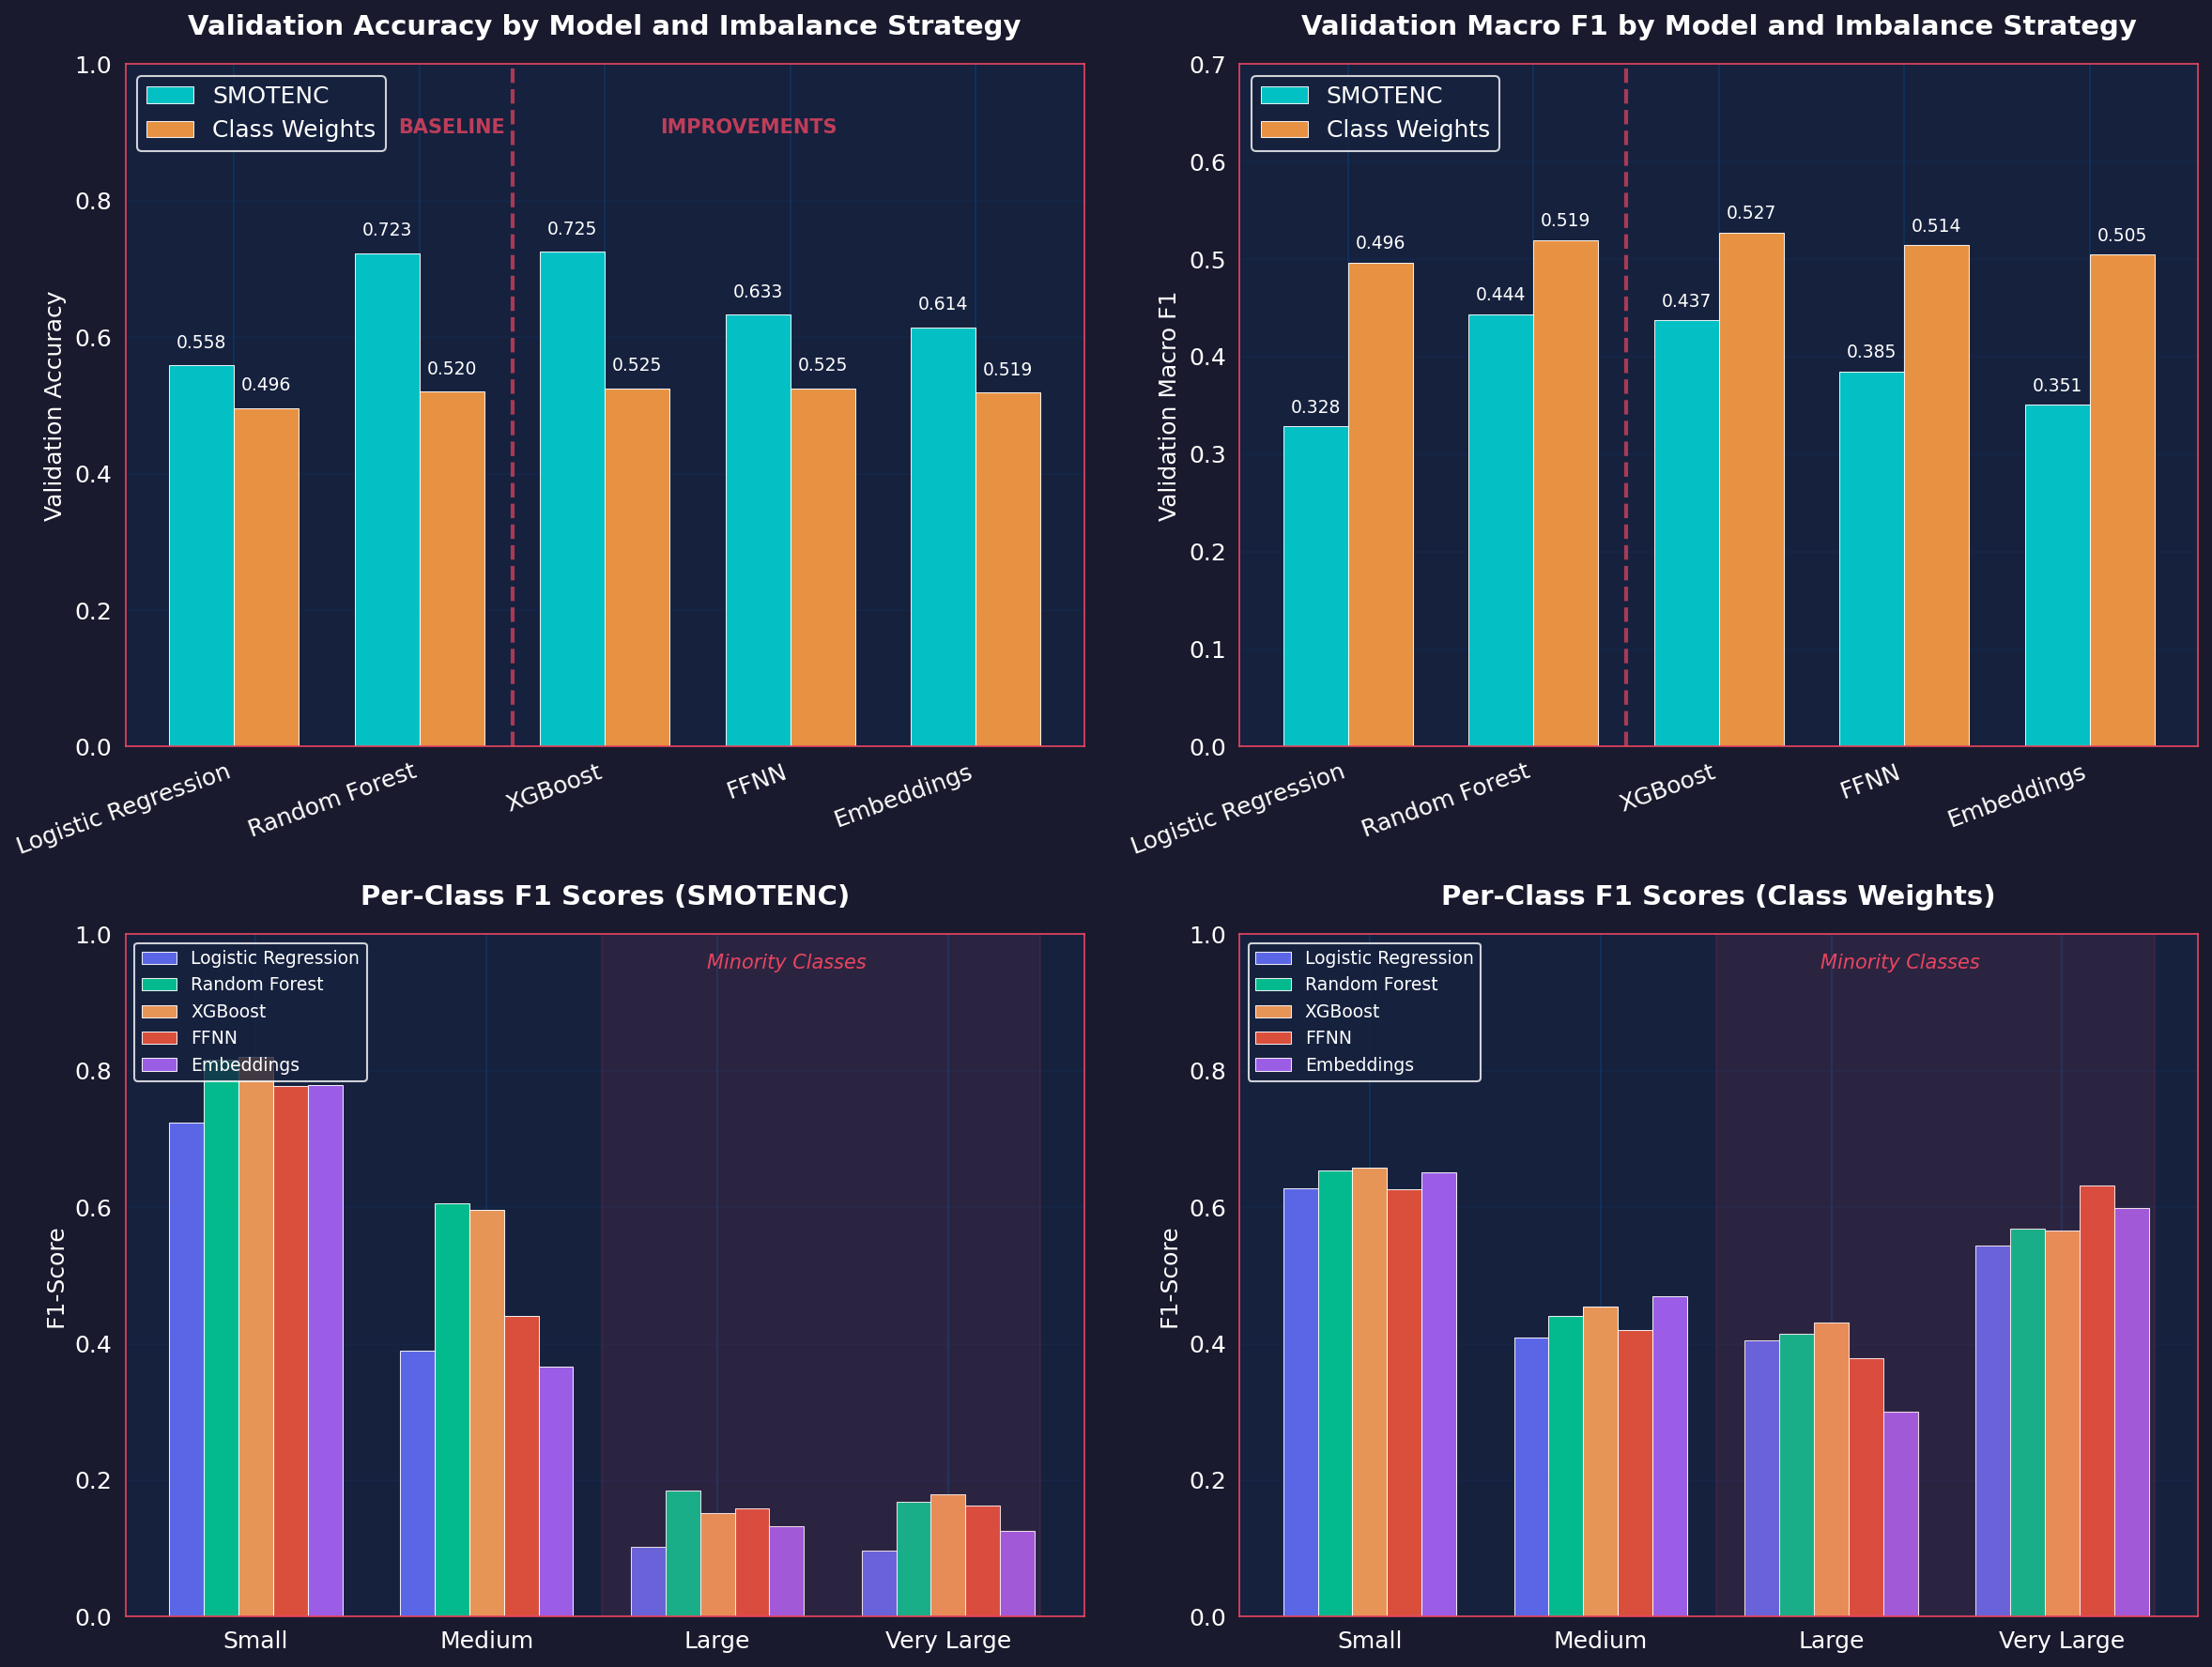

Saved: model_comparison.png


In [19]:
# Set presentation-ready style
plt.rcParams.update({
    'figure.facecolor': '#1a1a2e',
    'axes.facecolor': '#16213e',
    'axes.edgecolor': '#e94560',
    'axes.labelcolor': 'white',
    'text.color': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'grid.color': '#0f3460',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'figure.dpi': 150
})

# Color palette
MODEL_COLORS = {
    'Logistic Regression': '#636efa',   # blue
    'Random Forest': '#00cc96',          # green
    'XGBoost': '#ffa15a',                # orange
    'FFNN': '#ef553b',                   # red
    'Embeddings': '#ab63fa'              # purple
}

STRATEGY_COLORS = {
    'SMOTENC': '#00d2d3',      # cyan
    'Class Weights': '#ff9f43' # orange
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models = results_df['model'].unique()

# Plot 1: Validation Accuracy by Model and Strategy
ax1 = axes[0, 0]
x = np.arange(len(models))
width = 0.35

smote_acc = [results_df[(results_df['model'] == m) & (results_df['imbalance_strategy'] == 'SMOTENC')]['val_accuracy'].values[0] for m in models]
cw_acc = [results_df[(results_df['model'] == m) & (results_df['imbalance_strategy'] == 'Class Weights')]['val_accuracy'].values[0] for m in models]

bars1 = ax1.bar(x - width/2, smote_acc, width, label='SMOTENC',
                color=STRATEGY_COLORS['SMOTENC'], alpha=0.9, edgecolor='white', linewidth=0.5)
bars2 = ax1.bar(x + width/2, cw_acc, width, label='Class Weights',
                color=STRATEGY_COLORS['Class Weights'], alpha=0.9, edgecolor='white', linewidth=0.5)

# Baseline separator
ax1.axvline(x=1.5, color='#e94560', linestyle='--', linewidth=2, alpha=0.7)
ax1.text(0.34, 0.92, 'BASELINE', transform=ax1.transAxes, fontsize=10, fontweight='bold',
         verticalalignment='top', horizontalalignment='center', alpha=0.8, color='#e94560')
ax1.text(0.65, 0.92, 'IMPROVEMENTS', transform=ax1.transAxes, fontsize=10, fontweight='bold',
         verticalalignment='top', horizontalalignment='center', alpha=0.8, color='#e94560')

ax1.set_ylabel('Validation Accuracy')
ax1.set_title('Validation Accuracy by Model and Imbalance Strategy', fontweight='bold', pad=15)
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=20, ha='right')
ax1.legend(loc='upper left', facecolor='#16213e', edgecolor='white')
ax1.set_ylim(0, 1)
ax1.grid(axis='y', alpha=0.3)

for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9, color='white')
for bar in bars2:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9, color='white')

# Plot 2: Macro F1 by Model and Strategy
ax2 = axes[0, 1]

smote_f1 = [results_df[(results_df['model'] == m) & (results_df['imbalance_strategy'] == 'SMOTENC')]['val_macro_f1'].values[0] for m in models]
cw_f1 = [results_df[(results_df['model'] == m) & (results_df['imbalance_strategy'] == 'Class Weights')]['val_macro_f1'].values[0] for m in models]

bars1 = ax2.bar(x - width/2, smote_f1, width, label='SMOTENC',
                color=STRATEGY_COLORS['SMOTENC'], alpha=0.9, edgecolor='white', linewidth=0.5)
bars2 = ax2.bar(x + width/2, cw_f1, width, label='Class Weights',
                color=STRATEGY_COLORS['Class Weights'], alpha=0.9, edgecolor='white', linewidth=0.5)

ax2.axvline(x=1.5, color='#e94560', linestyle='--', linewidth=2, alpha=0.7)

ax2.set_ylabel('Validation Macro F1')
ax2.set_title('Validation Macro F1 by Model and Imbalance Strategy', fontweight='bold', pad=15)
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=20, ha='right')
ax2.legend(loc='upper left', facecolor='#16213e', edgecolor='white')
ax2.set_ylim(0, 0.7)
ax2.grid(axis='y', alpha=0.3)

for bar in bars1:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9, color='white')
for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=9, color='white')

# Plot 3: Per-Class F1 Scores (SMOTENC)
ax3 = axes[1, 0]
smote_df = results_df[results_df['imbalance_strategy'] == 'SMOTENC']
class_f1_cols = ['val_f1_small', 'val_f1_medium', 'val_f1_large', 'val_f1_very_large']
class_labels = ['Small', 'Medium', 'Large', 'Very Large']

x_class = np.arange(len(class_labels))
width_class = 0.15

for i, model in enumerate(smote_df['model'].values):
    model_data = smote_df[smote_df['model'] == model]
    f1_values = [model_data[col].values[0] for col in class_f1_cols]
    ax3.bar(x_class + i * width_class, f1_values, width_class,
            label=model, color=MODEL_COLORS[model], alpha=0.9, edgecolor='white', linewidth=0.5)

ax3.set_ylabel('F1-Score')
ax3.set_title('Per-Class F1 Scores (SMOTENC)', fontweight='bold', pad=15)
ax3.set_xticks(x_class + width_class * 2)
ax3.set_xticklabels(class_labels)
ax3.legend(loc='upper left', fontsize=9, facecolor='#16213e', edgecolor='white')
ax3.set_ylim(0, 1)
ax3.grid(axis='y', alpha=0.3)

# Highlight minority classes
ax3.axvspan(1.8, 3.7, alpha=0.1, color='#e94560')
ax3.text(2.6, 0.95, 'Minority Classes', ha='center', fontsize=10, color='#e94560', fontstyle='italic')

# Plot 4: Per-Class F1 Scores (Class Weights)
ax4 = axes[1, 1]
cw_df = results_df[results_df['imbalance_strategy'] == 'Class Weights']

for i, model in enumerate(cw_df['model'].values):
    model_data = cw_df[cw_df['model'] == model]
    f1_values = [model_data[col].values[0] for col in class_f1_cols]
    ax4.bar(x_class + i * width_class, f1_values, width_class,
            label=model, color=MODEL_COLORS[model], alpha=0.9, edgecolor='white', linewidth=0.5)

ax4.set_ylabel('F1-Score')
ax4.set_title('Per-Class F1 Scores (Class Weights)', fontweight='bold', pad=15)
ax4.set_xticks(x_class + width_class * 2)
ax4.set_xticklabels(class_labels)
ax4.legend(loc='upper left', fontsize=9, facecolor='#16213e', edgecolor='white')
ax4.set_ylim(0, 1)
ax4.grid(axis='y', alpha=0.3)

# Highlight minority classes
ax4.axvspan(1.8, 3.7, alpha=0.1, color='#e94560')
ax4.text(2.6, 0.95, 'Minority Classes', ha='center', fontsize=10, color='#e94560', fontstyle='italic')

plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=300, bbox_inches='tight',
            facecolor='#1a1a2e', edgecolor='none')
plt.show()
print("Saved: model_comparison.png")

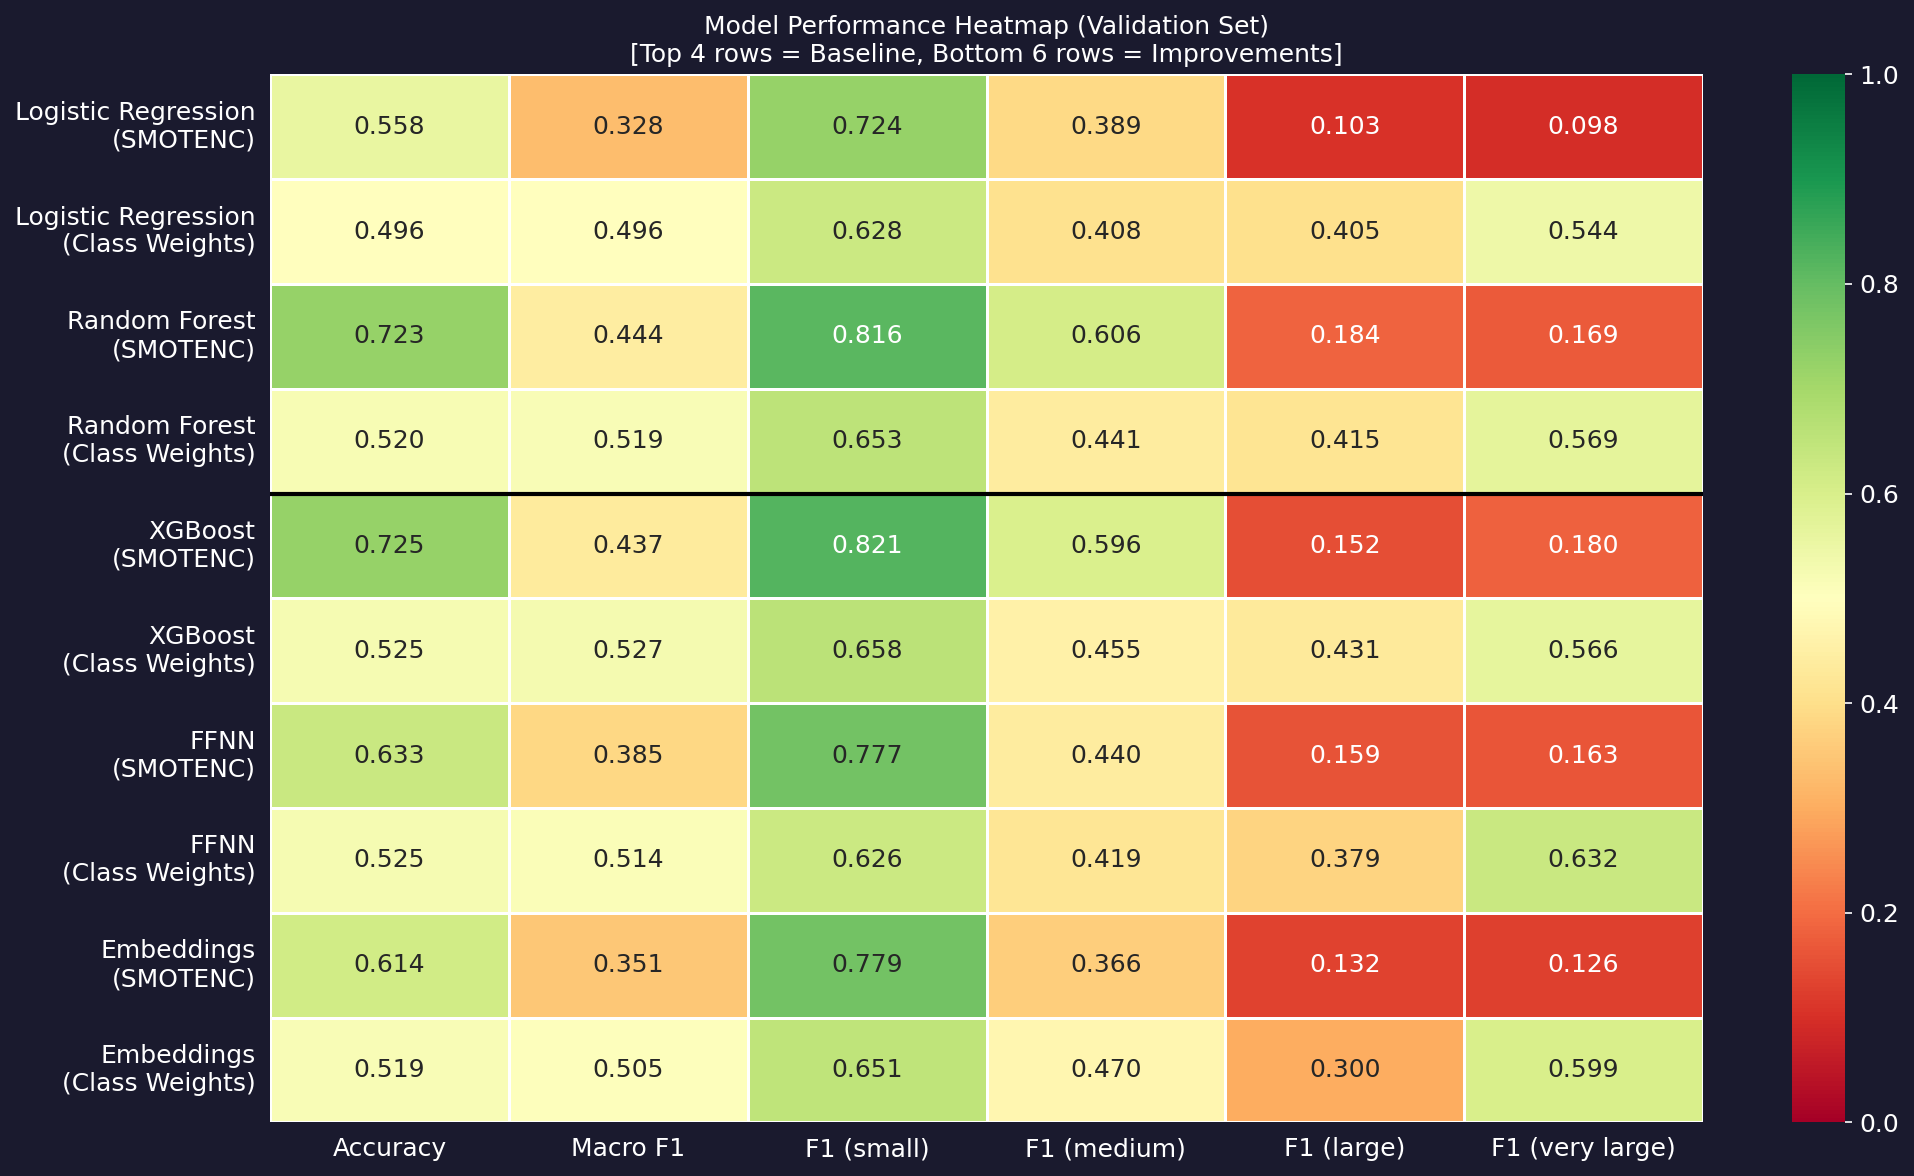

In [20]:
# Heatmap of all metrics
fig, ax = plt.subplots(figsize=(14, 8))

# Create a combined index for the heatmap
results_df['model_strategy'] = results_df['model'] + '\n(' + results_df['imbalance_strategy'] + ')'

# Reorder to group baselines together
order = [
    'Logistic Regression\n(SMOTENC)', 'Logistic Regression\n(Class Weights)',
    'Random Forest\n(SMOTENC)', 'Random Forest\n(Class Weights)',
    'XGBoost\n(SMOTENC)', 'XGBoost\n(Class Weights)',
    'FFNN\n(SMOTENC)', 'FFNN\n(Class Weights)',
    'Embeddings\n(SMOTENC)', 'Embeddings\n(Class Weights)'
]
results_df['model_strategy'] = pd.Categorical(results_df['model_strategy'], categories=order, ordered=True)
results_df_sorted = results_df.sort_values('model_strategy')

# Select key metrics for heatmap
heatmap_cols = ['val_accuracy', 'val_macro_f1', 'val_f1_small', 'val_f1_medium', 'val_f1_large', 'val_f1_very_large']
heatmap_data = results_df_sorted.set_index('model_strategy')[heatmap_cols]

# Rename cols
heatmap_data.columns = ['Accuracy', 'Macro F1', 'F1 (small)', 'F1 (medium)', 'F1 (large)', 'F1 (very large)']

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn',
            vmin=0, vmax=1, ax=ax, linewidths=0.5)

# separator line between baseline and improvement
ax.axhline(y=4, color='black', linewidth=2)

ax.set_title('Model Performance Heatmap (Validation Set)\n[Top 4 rows = Baseline, Bottom 6 rows = Improvements]', fontsize=12)
ax.set_xlabel('')
ax.set_ylabel('')

plt.tight_layout()
plt.savefig('../reports/model_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

# Export to Reports

In [21]:
# Export results to CSV
results_df.to_csv('../reports/model_comparison_results.csv', index=False)
print("Results exported to 'model_comparison_results.csv'")

Results exported to 'model_comparison_results.csv'
